# TODOs

1. Improve speed when computing the compatibility matrices, then run performance measures + chart for this method
2. Plot performance metrics for each case, using output from run_gale_shapley
3. Apply techniques to improve algorithm performance and maximize number of offers given out, then test on larger dataset
4. Refactor and add comments
5. Write README file

# Candidate-Role Recommender System

The aim of this project is to come up with a solution capable of accurately suggest candidates suitable for a particular job advertisement. I will proceed by conducting some exploratory data analysis on the (randomly generated) datasets, to then proceed with the implementation of common matchmaking algorithms as well as machine learning regression and classification techniques. 
Finally, I will analyse the performance of each approach and select a suitable option.

In [521]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set matplotlib inline styles
%matplotlib inline

# load the datasets into pandas dataframes
jobs = pd.read_csv('jobs.csv')
candidates = pd.read_csv('candidates.csv')

In [522]:
# checkout the head of the jobs dataframe
jobs.head()

,Title,Company,Field,MinScore,Positions
0,Dental Hygienist Internship,"Jimenez, Carney and Foley",physiotherapy,76,7
1,Registered Nurse Placement,"Roth, Rose and Cross",nutrition,81,8
2,Dental Hygienist Internship,Russell-Banks,nutrition,87,10
3,Dental Hygienist Internship,Martin Ltd,immunology,79,3
4,Physician Internship,Lambert Group,nutrition,80,9


In [523]:
# checkout the head of the candidates dataframe
candidates.head()

,Fullname,Course,Score,Experience,StudyMode,StudyPattern
0,Ashley Harris,Doctor of Pharmacy (Pharm.D.),96,nutrition,NaN,FT
1,Maria Harris,Master of Health Administration (M.H.A.),77,surgery,NaN,FT
2,Thomas Boyer,Bachelor of Science in Biomedical Science (B.S.),86,immunology,online,NaN
3,Holly Friedman,Bachelor of Science in Nursing (B.S.N.),82,physiotherapy,online,NaN
4,Rebecca Cook DVM,Doctor of Pharmacy (Pharm.D.),63,nursing,NaN,NaN


## Candidates data cleaning

In this section, both dataframes are prepared for future data visualization and prepared according to the algorithm utilised. 

In [524]:
# Replace all NaN values each dataframe column with a more appropriate value
candidates["Experience"].fillna("None", inplace=True)
candidates.fillna("N/A", inplace=True)

In [525]:
# Unify the StudyMode and StudyPattern columns, since they are less likely to be a decisive factor
# when calculating the relevance score of a candidate for a given job position
candidates['StudyProgram'] = candidates[["StudyMode", "StudyPattern"]].agg('-'.join, axis=1)

In [526]:
def clean(program):
    program = program.split("-")
    study_mode, study_pattern = program[0], program[1]
    
    if study_mode == "N/A" and study_pattern == "N/A":
        # Assume student is campus, fulltime
        return "Campus-FT"
    
    if study_mode == "N/A":
        # Assume student in oncampus
        return f"Campus-{study_pattern}"
    
    if study_pattern == "N/A":
        # Assume student is fulltime
        return f"{study_mode.capitalize()}-FT"
    
    # Both entries are specified
    return f"{study_mode.capitalize()}-{study_pattern}"

# Drop the unified columns
candidates.drop(["StudyMode", "StudyPattern"], axis=1, inplace=True)

# Handle null-values in the StudyProgram column
candidates["StudyProgram"] = candidates["StudyProgram"].apply(clean)

In [527]:
# checkout the head of candidates dataframe to see new dataframe
candidates.head()

,Fullname,Course,Score,Experience,StudyProgram
0,Ashley Harris,Doctor of Pharmacy (Pharm.D.),96,nutrition,Campus-FT
1,Maria Harris,Master of Health Administration (M.H.A.),77,surgery,Campus-FT
2,Thomas Boyer,Bachelor of Science in Biomedical Science (B.S.),86,immunology,Online-FT
3,Holly Friedman,Bachelor of Science in Nursing (B.S.N.),82,physiotherapy,Online-FT
4,Rebecca Cook DVM,Doctor of Pharmacy (Pharm.D.),63,nursing,Campus-FT


## Jobs data cleaning

 The round_to_closest function generalizes the MinScore into categories of multiples of 5. This may negatively influence the matchmaking process
 as some candidates may be wrongfully matched based on the rounded score, however it does simplify the matching process
 since there are less values the MinScore feature can take on.

In [528]:
def round_to_closest(x):
    
    # Extract the unitary digit
    unitary = int(x) % 10
    
    # Extract the decimal digit
    decimal = int(x)//10
      
    # Round up or down based on unitary digit
    if unitary < 5: 
        return decimal * 10
    if unitary == 5:
        return x
    else:
        return (decimal + 1) * 10
    

In [529]:
# Round the values in the MinScore column to the nearest 5%
jobs['MinScore'] = jobs['MinScore'].apply(round_to_closest)

In [530]:
# Checkout the head of the modified dataframe
jobs.head()

,Title,Company,Field,MinScore,Positions
0,Dental Hygienist Internship,"Jimenez, Carney and Foley",physiotherapy,80,7
1,Registered Nurse Placement,"Roth, Rose and Cross",nutrition,80,8
2,Dental Hygienist Internship,Russell-Banks,nutrition,90,10
3,Dental Hygienist Internship,Martin Ltd,immunology,80,3
4,Physician Internship,Lambert Group,nutrition,80,9


## Exploratory data visualization and analysis

In this section, the visualization libraries imported at the top of the notebook are put to use to plot both datasets and hopefully discover trends which could be relevant in the later stages of this experiment

### Candidates

<Axes: xlabel='Score', ylabel='Count'>

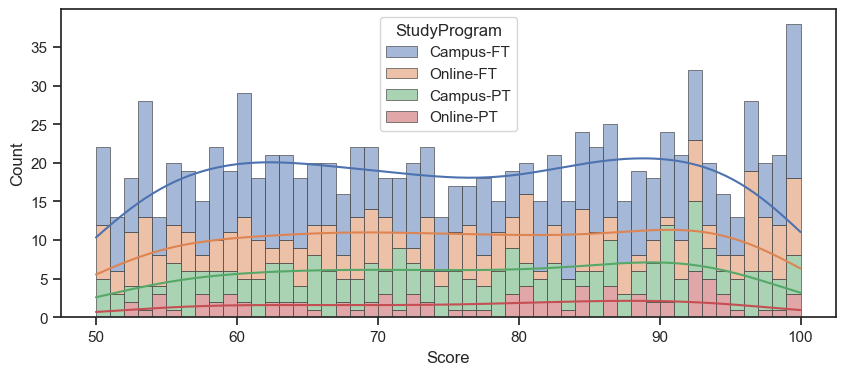

In [531]:
sns.set_theme(style="ticks")
sns.color_palette("PuOr", as_cmap=True)
plt.figure(figsize=(10, 4))

# Histogram plot of scores split between different study-programs
sns.histplot(data=candidates, x="Score", multiple="stack", hue='StudyProgram',edgecolor=".3", bins=50, linewidth=.5, kde=True)

From the above histogram, we can observe that the study-mode and study-pattern of a degree don't seem to affect a student's academic performance. This claim is backed up by the similarity in kernel-density line in the histogram above, as regardless of the study-program candidates tend to have a score between 60% and 85%, with some outliers scoring 100%.

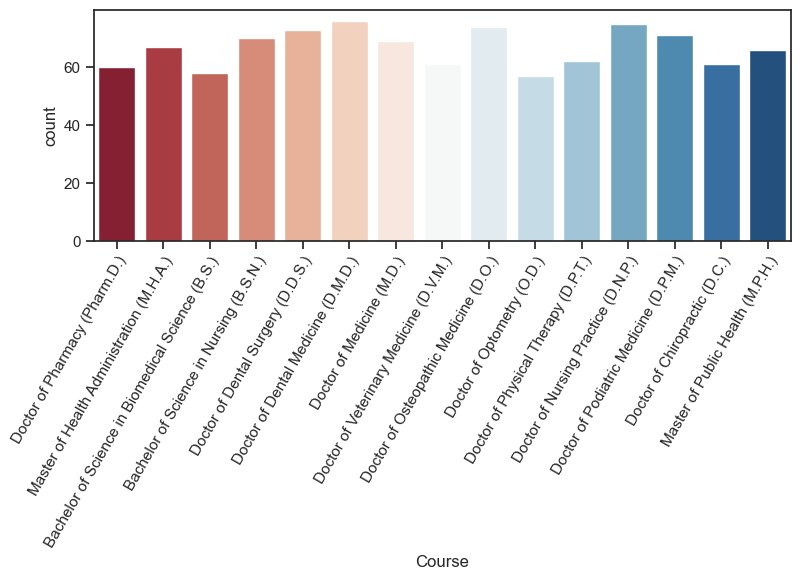

In [532]:
plt.figure(figsize=(9, 3))

# Histogram plot of scores split between different study-programs
chart = sns.countplot(data=candidates, x='Course', palette='RdBu', orient="v")
# Configure labels along the x-axis
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, ha="right", rotation_mode='anchor')
None # Hide the label objects

From the above countplot, we can see that for this particular batch of candidates, the majority are enrolled in Dentistry-related or Nursing/Medicine degree program, which requires that the corresponding batch of jobs must be rich in opportunities for these students, otherwise there's a risk of many of them going unmatched or matched to a less desirable job position

### Jobs

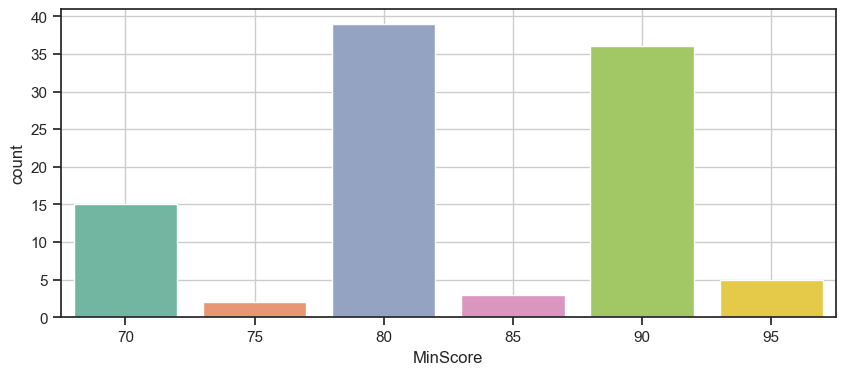

In [533]:
plt.figure(figsize=(10, 4))

# Countplot of companies grouped according to the minimum scored required for their positions
sns.countplot(data=jobs, x='MinScore', palette='Set2', orient="v")

# Display the background grid
plt.grid()

From the above countplot, we can observe that most positions require candidates to have a minimum score between 80-90%, with around 12 outliers requiring particularly high score of 95%. 

Comparing this countplot with the one for the student scores, the following can be deduced :
- Any student with a score below 70 risks of not getting matched to any internship
- The students with a score of 100 are likely to be matched to the positions requiring a 95% score. 

It is worth noting that a greedy algorithm might fail to compute a stable match, so for example a student with 100% score might be matched to an internship requiring a 70% instead of a more suitable 95% internship. This would also cause students with a score of 70% having their position stolen from the better students, leaving them potentially unmatched. 

The *Gale-Shapley* algorithm aims to avoid this problem.

In [534]:
# Total number of positions per job grouped by field of job
positions_per_field = jobs.groupby("Field").sum(numeric_only=True)["Positions"]

# Total number of students with experience grouped by field type
candidates_per_field = candidates["Experience"].value_counts()

field_df = pd.DataFrame(positions_per_field).join(candidates_per_field)

# Create a column to analyse the difference in job supply and demand in each field
field_df["Supply vs Demand"] = field_df["Positions"] - field_df["Experience"]

field_df

,Positions,Experience,Supply vs Demand
Field,,,
dentistry,126,127,-1
immunology,85,147,-62
nursing,115,144,-29
nutrition,177,148,29
physiotherapy,80,156,-76
surgery,107,155,-48


By the above analysis we can conclude that for these particular datasets :

- Physiotherapy has the highest demand to supply ratio, mostly due to the lower number of available job positions in the field
- The remaining fields seem to be abundant in jobs
- If this ratio were to be negative for a field, there's a risk of students remaining unmatched or having to accept a position in a field outside their preferred sector.

Based on these observations alone, and excluding factors such as a job's MinScore vs a student's Score it appears as if *not* every student will be matched to an internship in their field of expertise.

### Gale-Shapley Algorithm

# ===== Explaination of the G.S. Algorithm here ====================

In [535]:
import random

# Return a score to classify the compatibility of a candidate to a job
def compute_compatibility(candidate, job):
    compatibility_score = 0
    
    # Check if student has similar experience
    if candidate["Experience"] == job["Field"]:
        compatibility_score += 1
    else:
        compatibility_score += 0.5
    
    # Assign a reduced factor based on how far off the MinScore the candidate's score is
    candidate_score = candidate["Score"]
    job_minscore = job["MinScore"]
    
    # Candidate will prefer job whose MinScore is closer to their achieved grade 
    if candidate_score <= 0.9 * job_minscore or candidate_score >= 1.1 * job_minscore:
        compatibility_score += 1
    elif candidate_score <= 0.75 * job_minscore or candidate_score >= 1.25 * job_minscore:
        compatibility_score += 0.5
    else:
        compatibility_score += 0.25
        
    # Account for a candidate preferring location, pay, company title etc.
    compatibility_score += random.random()
    
    return round(compatibility_score, 2)

### Performance Benchmark Wrapper

In [536]:
from functools import wraps
from time import time

# Decorator function to measure the time performance of function fn
def benchmark(fn):
    
    @wraps(fn)
    def wrapper(*args, **kwargs):
        
        # Save time snapshots before and after function call
        start_time = time()
        result = fn(*args, **kwargs)
        end_time = time()
        
        # Display time elapsed and return result of fn call
        print(f'Executed {fn.__name__}, Time Elapsed : {round(end_time - start_time, 3)} seconds')
        return result
    
    # return the wrapper function
    return wrapper 

Create a computability table, where each row is a student and each column a job position. 
The entry at position *(i, j)* is the compatibility score between student *i* and job *j*. 
The table will have *M x N* entries, where *M* is the number of candidates and *N* the number of representative jobs available

### Gale-Shapley control variables

In [537]:
# Control variables used by the Gale-Shapley algorithm
total_job_titles = len(jobs)
total_jobs_available = jobs.loc[:total_job_titles, "Positions"].sum()
total_candidates = len(candidates)

# Scale down the dataframes for testing purposes
# jobs = jobs.loc[:total_job_titles]
# candidates = candidates.loc[:total_candidates]

In [538]:
import sys
from time import sleep
from tqdm import trange

# Populate the compatibility matrix using the jobs and candidates dataframe
@benchmark
def populate_compatibility_matrix(matrix, candidates, jobs):
    for i in trange(len(candidates), file=sys.stdout, colour='GREEN'):
        for j in range(len(jobs)): 
            matrix.loc[(i, j)] = compute_compatibility(candidates.loc[i], jobs.loc[j])
        sleep(0)

In [539]:
# Compute the preference matrix for the given dataframes
def compute_preference_matrix(candidates, jobs):
    
    # Use jobs and candidates indices instead of fullname and company as it guarantees uniqueness
    jobs_indices = [ i for i in range(len(jobs)) ]
    candidate_indices = [ i for i in range(len(candidates)) ]

    # Create the compatibility dataframe/matrix
    compatibility = pd.DataFrame(0, index=candidate_indices, columns=jobs_indices)
    compatibility = compatibility.rename_axis(index='Candidate IDs', columns='Job IDs')

    # Populate the compatibility matrix
    print("Populating the Compatibility matrix...")
    populate_compatibility_matrix(compatibility, candidates, jobs)
    print("Population operation completed.")
    
    return compatibility

In [540]:
# Given a list of jobs, return the index of a job with offers to still give out, or -1 if none are found
def find_job(company_ids):
    for i in range(len(company_ids)):
        if company_ids[i] >= 0:
            return i
    return -1

def suitable_candidates(company_index, compatibility_matrix):
    # Retrieve the column with key of company_index from the compatibility matrix
    suit_cands = [(i, compatibility_matrix[company_index][i]) for i in range(len(compatibility_matrix[company_index]))]
    # Sort the candidates by their compatibility score descending, so company makes offer to most relevant candidates first
    suit_cands.sort(key = lambda x: x[1])
    return suit_cands
    
# Display all the offers made in a user-readable format
def format_pairings(offers):
    for candidate_id in offers.keys():
        candidate_name = candidates.loc[candidate_id, "Fullname"]
        job_title = "N/A" if offers[candidate_id][0] == None else jobs.loc[offers[candidate_id][0], "Title"]
        print(f'{candidate_name} -> {job_title}')
        

In [541]:
@benchmark
def gale_shapley(company_ids, offers, compatibility_matrix, available_positions, max_iterations=10000):
    
    # Keep track of number of companies fulfilled at each iteration
    fulfillments = []
    iterations = 0
    while iterations < max_iterations:
        # find a company with job offers to give out
        company_id = find_job(company_ids)
        # stop condition when all companies have given out jobs
        if company_id == -1: break
        # Job J with positions still to fill-out
        j = company_ids[company_id]
        # find most compatible candidate who company j has not offered a job to yet
        comps = suitable_candidates(j, compatibility_matrix)
        # check whether all students reject this company
        all_reject = True
        for candidate in comps:
            candidate_id = candidate[0]
            # Make an offer to this candidate
            if j not in offers[candidate_id][1]:
                # check if candidate has no offer yet
                if offers[candidate_id][0] == None:
                    # Make the offer 
                    offers[candidate_id][0] = j
                    # Change reject status
                    all_reject = False
                    # Reduce number of jobs available for job j
                    available_positions[j] -= 1
                    # Check number of positions 
                    if available_positions[j] == 0:
                        # All positions have been filled
                        company_ids[j] = -1
                        break
                    # make sure this company cannot make another offer to the same candidate
                    offers[candidate_id][1].append(company_id)
                    break
                else:
                    # Make offer, then candidate chooses the company they compare best with
                    k = offers[candidate_id][0] # id of company candidate has an offer from
                    prev_offer_score = compatibility_matrix.loc[candidate_id, k]
                    curr_offer_score = compatibility_matrix.loc[candidate_id, j]
                    if curr_offer_score > prev_offer_score:
                        # candidate accepts new offer 
                        offers[candidate_id][0] = j
                        # change reject status
                        all_reject = False
                        # old offer now becomes free
                        available_positions[k] += 1
                        # current job position is not available to other candidates, so decrement
                        available_positions[j] -= 1
                        # check if old job has new positions free
                        if available_positions[k] == 1: 
                            company_ids[k] = k    
                        # check if new job has been completely filled out
                        if available_positions[j] == 0: 
                            company_ids[j] = -1  
                    else:
                        # candidate rejects new offer - add this company to the banned list for this candidate
                        offers[candidate_id][1].append(company_id)
                    break
        # If company rejected by all students, then remove it from being considered next
        if all_reject:
            company_ids[j] = -1
        # Save number of fulfilled companies after current iteration
        fulfillments.append(company_ids.count(-1))
        iterations += 1
    if iterations >= max_iterations:
        print("Termination due to time-out")
    return [offers, fulfillments]

### Gale-Shapley perfomance analysis

In [542]:
from time import time

# Run the Gale-Shapley algorithm for a range of candidates and jobs
def run_gale_shapley(number_of_candidates, number_of_jobs):
    
        start_time = time()
        
        print(f"\nRunning Gale-Shapley for {number_of_candidates} candidates and {number_of_jobs} jobs...")
    
        # Reduce size of candidates and jobs dataframes 
        candidates_dataframe = candidates.loc[:number_of_candidates]
        jobs_dataframe = jobs.loc[:number_of_jobs]
        
        # Compute the compatibility matrix
        compatibility_matrix = compute_preference_matrix(candidates_dataframe, jobs_dataframe)
        
        # Keeps track of companies with job offers to still give out 
        company_ids = compatibility_matrix.columns.tolist()

        # Keeps track of the offers made so far, candidate_id : (current_offer_company_id, [refusing_company_id1, ...])
        offers = { candidate_id : [None, []] for candidate_id in range(number_of_candidates + 1) }

        # Keeps track of the number of positions left per job
        available_positions = [ jobs_dataframe.loc[job_id, "Positions"] for job_id in range(len(jobs_dataframe)) ]
        
        # Compute the total number of positions across number_of_jobs jobs
        total_jobs = sum(available_positions)
        
        # Run the Gale-Shapley algorithm between the jobs and candidates dataset
        offers, fulfillments = gale_shapley(company_ids, offers, compatibility_matrix, available_positions)
        
        # Store number of input candidates and input jobs alongside number of matches constructed by gale_shapley
        candidates_with_offers = len([ candidate_id for candidate_id in offers.keys() if offers[candidate_id] != 1 ])
        jobs_assigned = candidates_with_offers
        percentage_metrics = (number_of_candidates, total_jobs, min(candidates_with_offers, number_of_candidates), min(total_jobs, jobs_assigned))
        
        # Compute iterations of this algorithm call
        iterations = len(fulfillments)
        
        # Compute time of execution
        elapsed_time = round(time() - start_time, 2)
        
        return (fulfillments[::-1], iterations, percentage_metrics, elapsed_time)

In [543]:
# Compute lineplots for the performance of the algorithm over a range of candidates and jobs
performance_data = [ run_gale_shapley(i, j) for j in range(25, 125, 25) for i in range(100, 1100, 100) ]


Running Gale-Shapley for 100 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 101/101 [00:00<00:00, 103.84it/s]
Executed populate_compatibility_matrix, Time Elapsed : 0.997 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.056 seconds

Running Gale-Shapley for 200 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 201/201 [00:01<00:00, 113.45it/s]
Executed populate_compatibility_matrix, Time Elapsed : 1.774 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.149 seconds

Running Gale-Shapley for 300 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 301/301 [00:02<00:00, 113.61it/s]
Executed populate_compatibility_matrix, Time Elapsed : 2.653 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.212 seconds

Running Gale-Shapley for 400 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|███

Executed gale_shapley, Time Elapsed : 1.431 seconds

Running Gale-Shapley for 800 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 801/801 [00:19<00:00, 41.01it/s]
Executed populate_compatibility_matrix, Time Elapsed : 19.538 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 1.621 seconds

Running Gale-Shapley for 900 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 901/901 [00:21<00:00, 41.08it/s]
Executed populate_compatibility_matrix, Time Elapsed : 21.934 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 1.892 seconds

Running Gale-Shapley for 1000 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s]
Executed populate_compatibility_matrix, Time Elapsed : 27.888 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 2.313 seconds

Running Gale-Shapley for 100 candidates and 100

### Perfomance measure : Jobs to be assigned vs Iterations

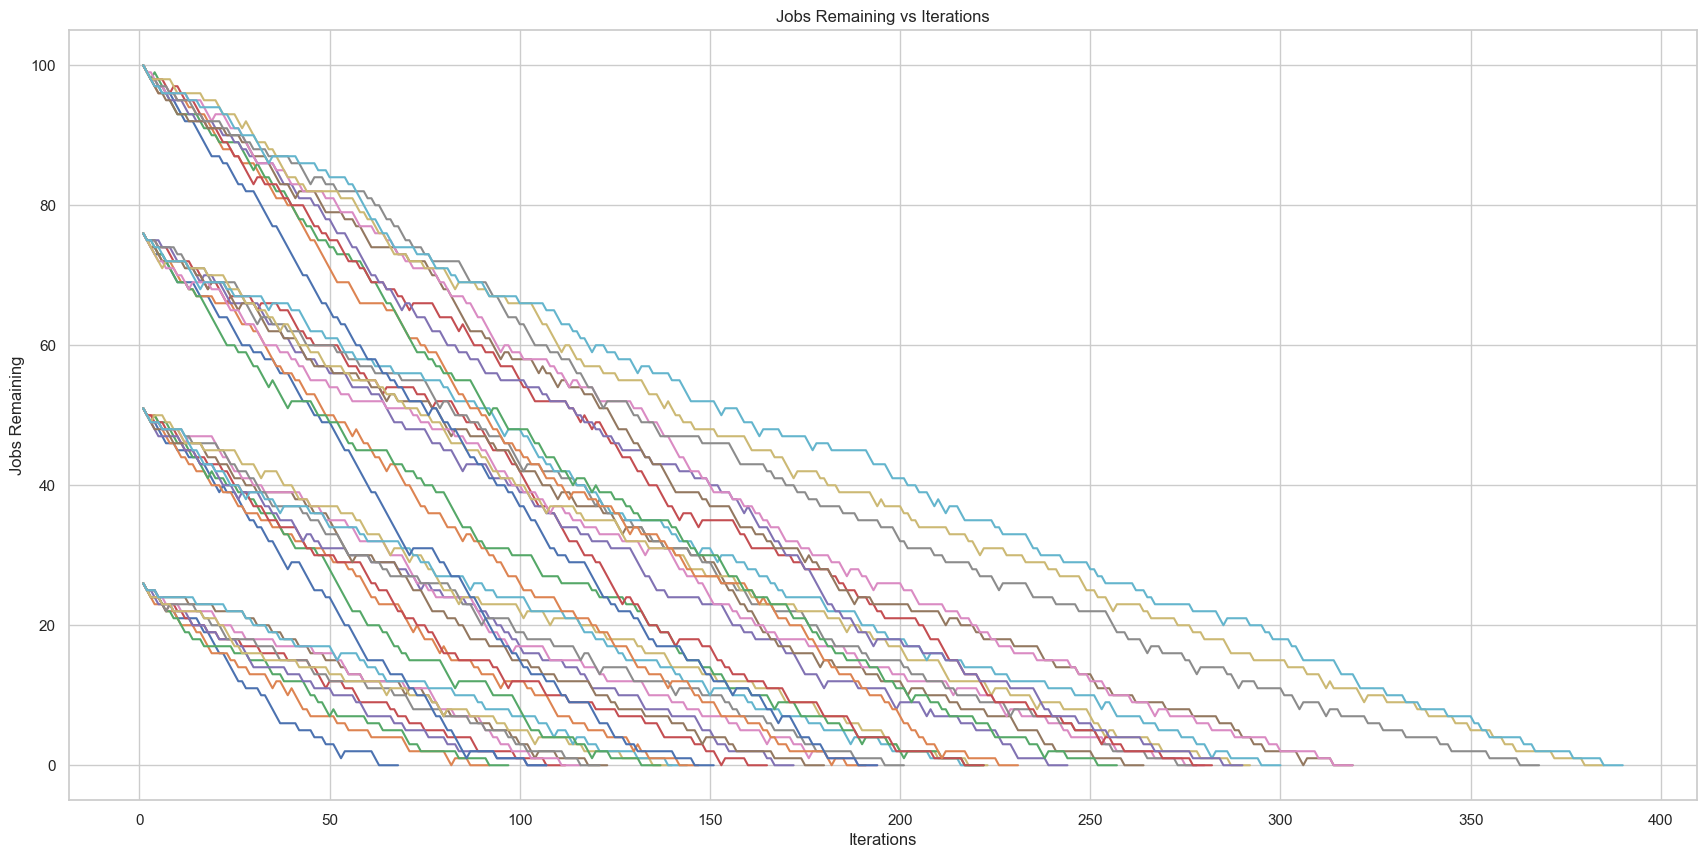

In [629]:
# Set the style for the plot
plt.figure(figsize=(21, 10))
sns.set(style="whitegrid")

iterations_outer_index = [ i for i in range(100, 1100, 100) ]
iterations_inner_index = [ i for i in range(25, 125, 25) ]
iterations_multi_index = pd.MultiIndex.from_product([iterations_outer_index, iterations_inner_index], names=['Candidates', 'Jobs Advertised'])

# Create a DataFrame with the MultiIndex for the Iterations data
iterations_data = {
    'Iterations' : [ data_tuple[1] for data_tuple in performance_data ],
    'Jobs Remaining' : [ data_tuple[0] for data_tuple in performance_data ]
}

iterations_df = pd.DataFrame(data=iterations_data, index=iterations_multi_index)

for i in range(len(iterations_df)):
    curr_row = iterations_df.iloc[i]
    
    # Convert the 'Jobs Remaining' column to a list of lists
    jobs_remaining_list = curr_row['Jobs Remaining']

    # Create a DataFrame for the current row
    df_curr_row = pd.DataFrame({'Iterations': range(1, len(jobs_remaining_list) + 1), 'Jobs Remaining': jobs_remaining_list})
    
    # Create the line plot
    sns.lineplot(data=df_curr_row, x='Iterations', y='Jobs Remaining')
    
# Set plot labels and title
plt.title('Jobs Remaining vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Jobs Remaining')
plt.show()

### Perfomance measure : % of candidates assigned and % of jobs assigned per input size

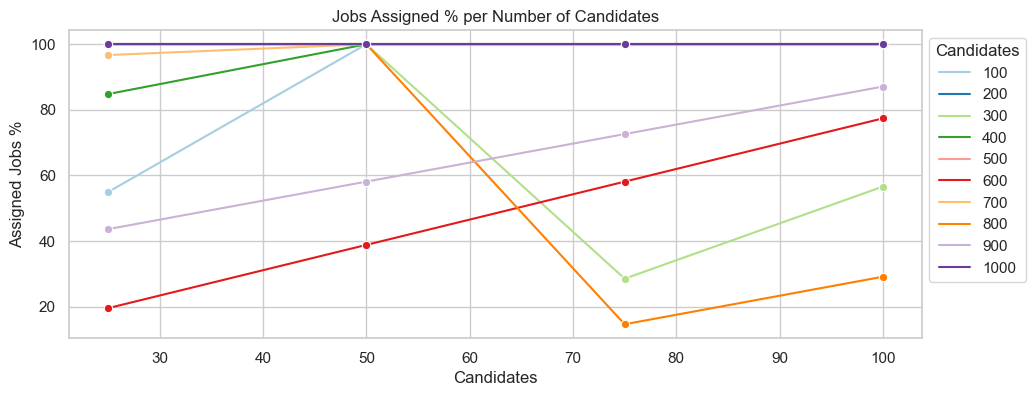

In [604]:
percentage_outer_index = [ i for i in range(100, 1100, 100) ]
percentage_inner_index = [ i for i in range(25, 125, 25) ]
percentage_multi_index = pd.MultiIndex.from_product([percentage_outer_index, percentage_inner_index], names=['Candidates', 'Jobs Advertised'])

# Create a dataframe with the MultiIndex for the Assignment percentage data
percentage_data = {
    'Assigned Candidates %' : [ round(100 * data_tuple[2][2]/data_tuple[2][0], 1) for data_tuple in performance_data ],
    'Assigned Jobs %' : [ round(100 * data_tuple[2][3]/data_tuple[2][1], 1) for data_tuple in performance_data ]
            }

percentage_df = pd.DataFrame(data=percentage_data, index=percentage_multi_index)

# Plot the above dataframe
sns.set(style="whitegrid")

plt.figure(figsize=(11, 4))
percentage_chart = sns.lineplot(data=percentage_df.reset_index(), x='Jobs Advertised', y='Assigned Jobs %', palette='Paired', hue='Candidates', marker='o')

plt.title('Jobs Assigned % per Number of Candidates')
plt.xlabel('Candidates')
plt.ylabel('Assigned Jobs %')

sns.move_legend(percentage_chart, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [607]:
# Let's see what the percentage_df indicates about the performance of the algorithm
percentage_df[percentage_df["Assigned Jobs %"] < 100.0]

Assigned Candidates %  Assigned Jobs %
Candidates Jobs Advertised                                        
100        25                               100.0             54.9
300        75                               100.0             28.5
           100                              100.0             56.6
400        25                               100.0             84.8
600        25                               100.0             19.5
           50                               100.0             38.8
           75                               100.0             58.1
           100                              100.0             77.4
700        25                               100.0             96.7
800        75                               100.0             14.6
           100                              100.0             29.1
900        25                               100.0             43.6
           50                               100.0             58.1
           75                               100.0             72.6
           100                              100.0             87.1

### Explaination for graph above

### Performance measure :  Time for Execution vs Input size 

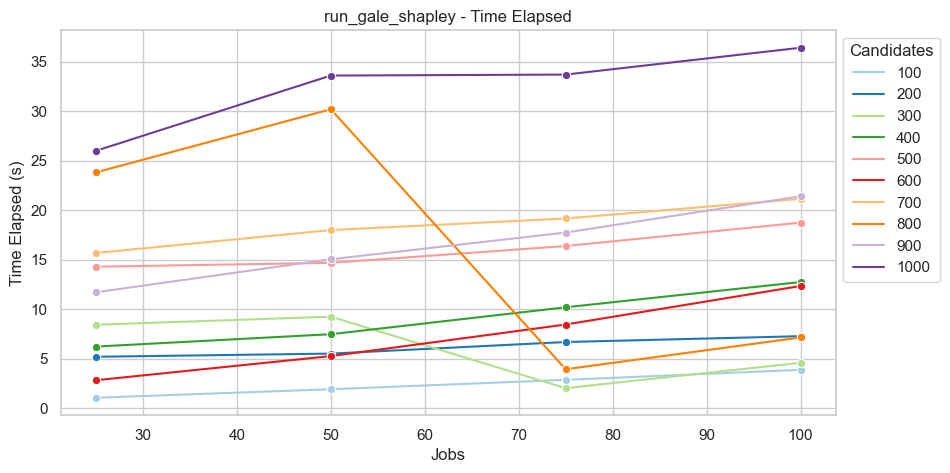

In [569]:
time_outer_index = [ i for i in range(100, 1100, 100) ]
time_inner_index = [ i for i in range(25, 125, 25) ]
time_multi_index = pd.MultiIndex.from_product([time_outer_index, time_inner_index], names=['Candidates', 'Jobs Advertised'])

# Create a DataFrame with the MultiIndex for the Time Elapsed data
time_data = {'Time Elapsed' : [ data_tuple[3] for data_tuple in performance_data ] }
time_df = pd.DataFrame(data=time_data, index=time_multi_index)

# Plot the above dataframe
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
time_chart = sns.lineplot(data=time_df.reset_index(), x='Jobs Advertised', y='Time Elapsed', palette='Paired', hue='Candidates', marker='o')

plt.title('run_gale_shapley - Time Elapsed')
plt.xlabel('Jobs')
plt.ylabel('Time Elapsed (s)')

sns.move_legend(time_chart, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### Explaination for graph above

# ========== analysis of the above 3 cells here ====================

altough graph reached 0 jobs to be assigned, 12.3% were not assigned. this is because company cannot make offer to same student over and over, so they are rejected the first time and cannot make offer again.

since we are computing the matrix over and over, the random factors value will affect the values in the matrix and to a small extent the behaviour of the algorithm when choosing the next candidate to make an offer to

above is analysis with expected input sizes given by the client, so around 500 students and 50 companies with varying positions per job.
below is an overall perfomance analysis of the algorithm, with ranges of 100 to 1500 students and 10 to 100 companies. graphs will analyse the time to run, number of jobs to be filled decay, and the percentage of offers for each test case.

### KNNs

### (Iterative) Linear Regression

### Expectation Maximization Algorithm

### Linear SVM

### Random Forest

### LambdaMART Algorithm

## Evaluation and Conclusion